In [1]:
from load_data import *
from helpers import *
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR, LinearSVR
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
import shap

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


Init Plugin
Init Graph Optimizer
Init Kernel


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_m1/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Final prediction models
Use several different models with the selected features and compare their results in terms of R^2 and MSE

Models:
- Random Forest
- XGBoost
- Neural Network
- SVR (?)
- Linear Regression

## Data Preparation

In [3]:
listings = pd.read_csv("/Users/dmnk/OneDrive - stud.uni-goettingen.de/Dokumente/3. Semester/SeminarDL/DubAir/Final_listings.csv")
listings.drop(listings.columns[0], axis = 1, inplace=True)

In [3]:
# Load data
price, listings = load_data()

#X_train, X_test, y_train, y_test = train_test_split(listings, price["log_price"], random_state = 123, test_size = 0.2)
model_score = []

Have fun implementing your models.


In [4]:
listings.rename(columns = {"property_type_Private room in residential home": "property_type_private_room_residential_home","property_type_Entire rental unit": "property_type_entire_rental_units"}, inplace = True)
listings["property_type_private_room_residential_home"] = listings["property_type_private_room_residential_home"].values.astype(np.int8)
listings["property_type_entire_rental_units"] = listings["property_type_entire_rental_units"].values.astype(np.int8)


In [5]:
listings["log_price"] = price["log_price"]
listings.to_csv("colab.csv")

## Define R^2

In [6]:
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.math.divide(residual, total))
  return r2

## Random Forest

In [85]:
space={'max_depth': hp.quniform("max_depth", 2, 100, 2),
        "min_samples_split": hp.quniform("min_samples_split", 2, 1000, 2),
        "max_features": hp.quniform("max_features", 2,24,2),
        'n_estimators': 200,
        'seed': 0
    }
    
def objective(space):
    model = RandomForestRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']))
    
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    print ("SCORE:", mse)
    return {'loss': mse, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.20827706082930889                                    
SCORE:                                                                            
0.22588902655672416                                                               
SCORE:                                                                            
0.24565732335228402                                                               
SCORE:                                                                            
0.2073041469721654                                                                
SCORE:                                                                            
0.24465746171678654                                                              
SCORE:                                                                           
0.2043852476700559                                                               
SCORE:                                                       

In [75]:
best_hyperparams
best_hyperparams["max_depth"] = int(best_hyperparams["max_depth"])

In [81]:
# train a Random Forest
forest = RandomForestRegressor(n_estimators = 200, max_depth = int(best_hyperparams['max_depth'])).fit(X_train, y_train)

Exception: waterfall_plot requires a scalar base_values of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.base_values[0], values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.base_values[0], values[0][0], X[0]).

In [82]:
forest.score(X_test, y_test)

0.6472476816005108

In [83]:
y_pred = forest.predict(X_test)
R_squared(y_test, y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.6472476816005109>

## XGBoost

In [67]:
space={'max_depth': hp.quniform("max_depth", 2, 50, 2),
        'gamma': hp.uniform ('gamma', 0, 9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,100),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 50, 1),
        'n_estimators': 500,
        'seed': 0
    }
    
def objective(space):
    model=xgb.XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    #evaluation = [(X_train, y_train), (X_test, y_test)]
    
    model.fit(X_train, y_train)
    

    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    print ("SCORE:", mse)
    return {'loss': mse, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [69]:
best_hyperparams
best_hyperparams["max_depth"] = int(best_hyperparams["max_depth"])

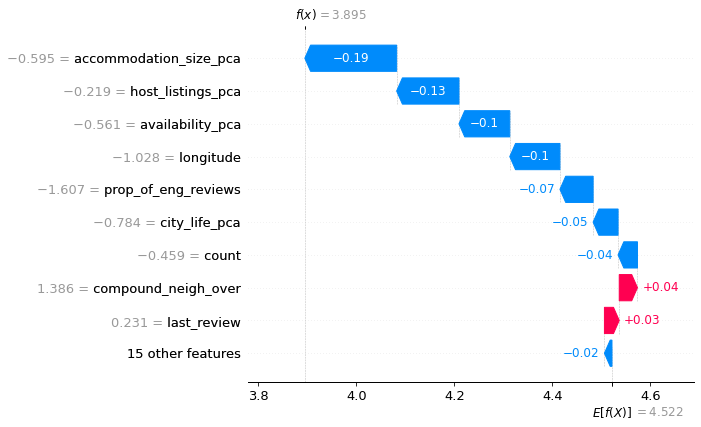

In [70]:
# train an XGBoost model
model = xgb.XGBRegressor(**best_hyperparams).fit(X_train, y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[10])

In [71]:
model.score(X_test, y_test)

0.6586311700421369

In [72]:
y_pred = model.predict(X_test)
R_squared(y_test,y_pred)

<tf.Tensor: shape=(), dtype=float64, numpy=0.658631170042137>

## Neural Network

Important parts:
- Regularization on the weights (L1 or L2)
- Dropout
- Layers (3 proposed in:
 @article{2021,
   title={Airbnb Price Prediction Using Machine Learning and Sentiment Analysis},
   ISBN={9783030840600},
   ISSN={1611-3349},
   url={http://dx.doi.org/10.1007/978-3-030-84060-0_11},
   DOI={10.1007/978-3-030-84060-0_11},
   journal={Machine Learning and Knowledge Extraction},
   publisher={Springer International Publishing},
   author={Rezazadeh Kalehbasti, Pouya and Nikolenko, Liubov and Rezaei, Hoormazd},
   year={2021},
   pages={173–184})

## TabNet

In [33]:
import tabnet
import tensorflow as tf

In [34]:
train_size = 6000
batch_size = 600

In [35]:
def transform(ds):
    features = tf.unstack(ds["features"])
    prices = ds["price"]

    x = dict(zip(col_names, features))
    y = prices
    return x, y

In [36]:
bin_col = [col for col in listings if np.isin(listings[col].unique(), [0, 1]).all()]
num_col = [col for col in listings if ~np.isin(listings[col].unique(), [0, 1]).all()]
col_names = bin_col + num_col

In [37]:
data = tf.data.Dataset.from_tensor_slices({"features": listings, "price": price["log_price"]})

In [38]:
data = data.shuffle(6000, seed = 13)
train_dataset = data.take(train_size)
train_dataset = train_dataset.map(transform)
train_dataset = train_dataset.batch(batch_size)
test_dataset = data.take(len(listings)-train_size)
test_dataset = test_dataset.map(transform)
test_dataset = test_dataset.batch(batch_size)

In [44]:
feature_columns = []
#for num in num_col:
 #   feature_columns.append(tf.feature_column.numeric_column(num))
#for binary in bin_col:
 #   feature_columns.append(tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(binary, ["No", "Yes"])))
 
for col in col_names:
    feature_columns.append(tf.feature_column.numeric_column(col))

In [47]:
model = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                output_dim=30,
                                num_decision_steps=4)

[TabNet]: 34 features will be used for decision steps.


In [43]:
#lr = 0.001
lr = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=400, decay_rate=0.9, staircase=False)
optimizer = tf.keras.optimizers.Adam(lr)
model.compile(optimizer, loss='mse', metrics=[R_squared])

model.fit(train_dataset, epochs=600, validation_data=test_dataset, verbose=1)

Epoch 1/600


2022-01-29 00:05:11.136849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 4.1425 - R_squared: -5.9133

2022-01-29 00:05:13.757247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 6s 218ms/step - loss: 4.1425 - R_squared: -5.9133 - val_loss: 0.6384 - val_R_squared: -0.0729
Epoch 2/600
10/10 [==============================] - 1s 123ms/step - loss: 0.5667 - R_squared: 0.0345 - val_loss: 0.4834 - val_R_squared: 0.0635
Epoch 3/600
10/10 [==============================] - 1s 127ms/step - loss: 0.4812 - R_squared: 0.1867 - val_loss: 0.5864 - val_R_squared: 0.2075
Epoch 4/600
10/10 [==============================] - 1s 123ms/step - loss: 0.4306 - R_squared: 0.2637 - val_loss: 0.4241 - val_R_squared: 0.2280
Epoch 5/600
10/10 [==============================] - 1s 134ms/step - loss: 0.4324 - R_squared: 0.2732 - val_loss: 0.3950 - val_R_squared: 0.2662
Epoch 6/600
10/10 [==============================] - 1s 124ms/step - loss: 0.4334 - R_squared: 0.2704 - val_loss: 0.3982 - val_R_squared: 0.3274
Epoch 7/600
10/10 [==============================] - 1s 123ms/step - loss: 0.4261 - R_squared: 0.2859 - val_loss: 0.4009 - val_R_squared: 0.

In [29]:
model.summary()

Model: "tab_net_regressor_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tab_net_7 (TabNet)           multiple                  83440     
_________________________________________________________________
regressor (Dense)            multiple                  10        
Total params: 83,450
Trainable params: 83,450
Non-trainable params: 0
_________________________________________________________________
Model: "tab_net_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_5 (DenseFeatu multiple                  0         
_________________________________________________________________
input_gn (GroupNormalization multiple                  48        
_________________________________________________________________
transform_block_83 (Transfor multiple                  3328      
________________________

In [67]:
model = tabnet.TabNet(feature_columns, 
                                output_dim=30,
                                num_decision_steps=4)

[TabNet]: 34 features will be used for decision steps.


In [56]:
len(listings.columns)

24

In [70]:
from tabnet.modeles.classify import TabNetClassifier

ModuleNotFoundError: No module named 'tabnet.modeles'

In [76]:
from tabnet.models.classify import TabNetClassifier


ModuleNotFoundError: No module named 'tensorflow_addons'

In [75]:
tabnet.models

AttributeError: module 'tabnet' has no attribute 'models'

## Support Vector Regression